In [136]:
import praw
import pandas as pd
import requests

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
import seaborn as sns
import re
from config import client_id,client_secret,user_agent,password,username

nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/michal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/michal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/michal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/michal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [138]:
game_1 = pd.read_csv("data/game_1.csv")
game_2 = pd.read_csv("data/game_2.csv")
game_3 = pd.read_csv("data/game_3.csv")
game_4 = pd.read_csv("data/game_4.csv")
game_5 = pd.read_csv("data/game_5.csv")
game_6 = pd.read_csv("data/game_6.csv")

games = [game_1,game_2,game_3,game_4,game_5,game_6]


In [139]:
def preprocess_text(text, method='lemmatization'):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Apply chosen method
    if method == 'stemming':
        stemmer = PorterStemmer()
        processed_tokens = [stemmer.stem(token) for token in tokens]
    elif method == 'lemmatization':
        lemmatizer = WordNetLemmatizer()
        processed_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else:
        raise ValueError("Invalid method. Choose either 'stemming' or 'lemmatization'.")

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(processed_tokens)

    return preprocessed_text

In [140]:
sia = SentimentIntensityAnalyzer()

game_number = 1
for game in games:

    
    # Apply pre-processing
    game['preprocessed_comments'] = game['body'].apply(lambda x: preprocess_text(x, method='lemmatization'))

    # Apply sentiment socring
    game['ss'] = game['preprocessed_comments'].apply(lambda x: sia.polarity_scores(x)['compound'])

    game["combined_ss"] = game["ss"] * game["score"]
    game["game_number"] = game_number

    print(f'game # {game_number}')
    print('Sentiment Score Mean and SD')
    print(game["ss"].mean(), game["ss"].std())
    print('Combined Sentiment Score Mean and SD')
    print(game["combined_ss"].mean(), game["combined_ss"].std())

    game_number += 1

game # 1
Sentiment Score Mean and SD
0.10632752100840336 0.4362355183045884
Combined Sentiment Score Mean and SD
1.9863220588235293 13.717044578083604
game # 2
Sentiment Score Mean and SD
-0.0002436708860759511 0.4194234623549459
Combined Sentiment Score Mean and SD
-0.24536244725738396 8.505678070257888
game # 3
Sentiment Score Mean and SD
0.019262909836065576 0.43692188434060547
Combined Sentiment Score Mean and SD
0.6886581967213115 9.916309928299986
game # 4
Sentiment Score Mean and SD
0.03724701030927835 0.4402560430552004
Combined Sentiment Score Mean and SD
0.5320420618556702 6.626361794338331
game # 5
Sentiment Score Mean and SD
0.025851738241308795 0.42799991042261565
Combined Sentiment Score Mean and SD
0.4605740286298569 7.229281164044706
game # 6
Sentiment Score Mean and SD
-0.009897963340122197 0.43554218422644303
Combined Sentiment Score Mean and SD
-0.3287639511201629 12.08605248216373


In [141]:
combined_df = pd.concat(games)
combined_df = combined_df.reset_index(drop=True)

combined_df['game_number'] = pd.Categorical(combined_df['game_number'].astype(str))

combined_df

,id,body,score,created_utc,parent_id,preprocessed_comments,ss,combined_ss,game_number
0,jin2fth,Filipino Civil War about to begin,216,1.683077e+09,t3_1365zfw,filipino civil war begin,-0.5994,-129.4704,1
1,jingvv2,The moment Poole hit that 3rd three you knew h...,100,1.683083e+09,t3_1365zfw,moment poole hit rd three knew gon na take dum...,-0.5106,-51.0600,1
2,jinruu4,Someone literally said earlier in the game lak...,81,1.683089e+09,t3_1365zfw,someone literally said earlier game lakers pla...,0.6908,55.9548,1
3,jin1h4k,"Flair up everyone. It’s going to get toxic, we...",211,1.683076e+09,t3_1365zfw,flair everyone going get toxic need know every...,0.0000,0.0000,1
4,jin03zs,Ah yes the battle of the two most respectful u...,242,1.683076e+09,t3_1365zfw,ah yes battle two respectful upstanding least ...,0.7833,189.5586,1
...,...,...,...,...,...,...,...,...,...
2898,jjyn921,"I was immediately thinking ""Damn Bron, that's ...",11,1.683952e+09,t3_13g2qr3,immediately thinking damn bron thats quite sel...,0.2960,3.2560,6
2899,jjyn98u,Lebron can still completely take over a game a...,10,1.683952e+09,t3_13g2qr3,lebron still completely take game year old abs...,0.0000,0.0000,6
2900,jjyn9dv,That’s right in the bridge of the nose those h...,10,1.683952e+09,t3_13g2qr3,thats right bridge nose hurt pretty fucking bad,-0.6115,-6.1150,6
2901,jjyn9gl,Lmfao why are the Lakers/Warriors so unlucky w...,9,1.683952e+09,t3_13g2qr3,lmfao lakerswarriors unlucky getting whacked f...,0.7003,6.3027,6


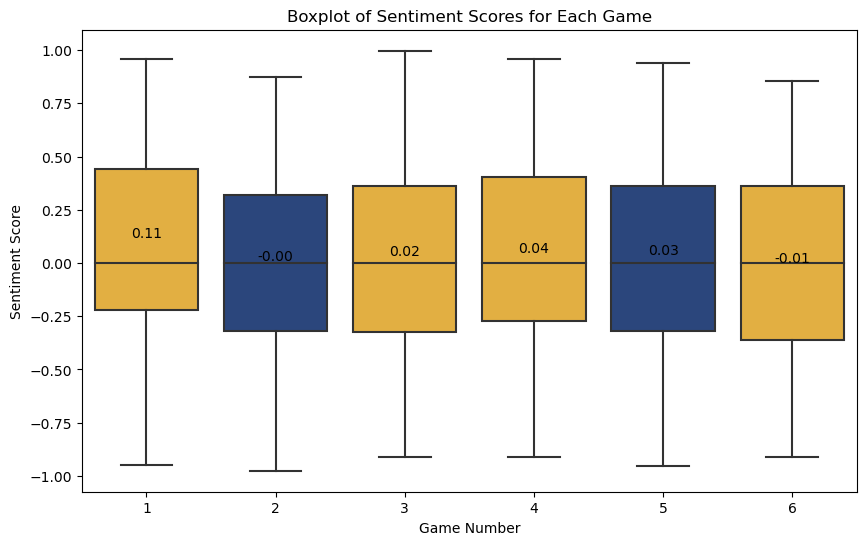

In [142]:
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size

colors = ['#FDB927', '#1D428A', '#FDB927','#FDB927', '#1D428A','#FDB927' ]


# Create a boxplot using Seaborn
sns.boxplot(data=combined_df, x='game_number', y='ss', palette = colors)

mean_scores = combined_df.groupby('game_number')['ss'].mean()

for i, mean_score in enumerate(mean_scores):
    plt.text(i, mean_score, f'{mean_score:.2f}', ha='center', va='bottom', fontweight='ultralight')
# Set plot labels and title

plt.xlabel('Game Number')
plt.ylabel('Sentiment Score')
plt.title('Boxplot of Sentiment Scores for Each Game')

# Show the plot
plt.show()

In [143]:
mean_scores = combined_df.groupby('game_number')['ss'].mean()
mean_scores

game_number
1    0.106328
2   -0.000244
3    0.019263
4    0.037247
5    0.025852
6   -0.009898
Name: ss, dtype: float64